In [39]:
import numpy as np
import xarray as xr
import stmat
import geopandas as gpd
import shapely as sp

Initialize raster coordinate information:

In [6]:
minx = 5 
maxx = 10
miny = 50
maxy = 55
dx = 0.5 #Resolution in x
dy = 0.5 #Resolution in y

nx = (maxx - minx)/dx
ny = (maxy - miny)/dy

Create synthetic data 

In [7]:
n_points = 10000
n_time = 1

synthetic h2ph data

In [8]:
stack = np.empty((n_points,0))

for i in range(1):
    slc= np.random.random((100,100))
    stack = np.append(stack, slc[0:100,0:100].reshape(n_points,1), axis=1)

stack = np.array(stack*10, dtype='int')
print(stack.shape)


(10000, 1)


Case 1: synthetic coords (sorted in x and y)

In [9]:
x = np.sort(np.random.random(100)*(maxx - minx) + minx)
y = np.sort(np.random.random(100)*(maxy - miny) + miny)

In [10]:
xx, yy = np.meshgrid(x,y)
xxreshape = xx.reshape(n_points,1)
yyreshape = yy.reshape(n_points,1)

In [11]:
stack_xx = np.empty((n_points,0))
stack_yy = np.empty((n_points,0))

for i in range(1):
    stack_xx = np.append(stack_xx, xxreshape, axis=1)
    stack_yy = np.append(stack_yy, yyreshape, axis=1)


Create Xarray object with coordinates as variables

In [12]:
data_xr = xr.Dataset(data_vars=dict(h2ph=(["points", "time"], stack), xv=(["points","time"],stack_xx),yv=(["points","time"],stack_yy),),
                     coords=dict(
                        points=np.arange(n_points),
                        time=np.arange(n_time),
                        ))

data_xr

<xarray.Dataset>
Dimensions:  (points: 10000, time: 1)
Coordinates:
  * points   (points) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * time     (time) int64 0
Data variables:
    h2ph     (points, time) int64 0 7 5 9 7 9 9 6 8 7 6 ... 7 6 2 8 1 0 4 8 0 2
    xv       (points, time) float64 5.066 5.101 5.155 ... 9.882 9.887 9.916
    yv       (points, time) float64 50.02 50.02 50.02 ... 54.95 54.95 54.95

Import rasterio and related module for rasterize

In [13]:
import rasterio
from rasterio import features
from rasterio import enums
import affine
import matplotlib.pyplot as plt

Convert xarray to geopandas data-frame for use in rasterize

In [14]:
df = data_xr.to_dataframe().reset_index()

gdf = gpd.GeoDataFrame(
    df.h2ph, geometry=gpd.points_from_xy(df.xv,df.yv))

gdf.sort_values('h2ph')

,h2ph,geometry
0,0,POINT (5.06621 50.02277)
6668,0,POINT (8.52725 53.33747)
6677,0,POINT (9.02441 53.33747)
6679,0,POINT (9.07343 53.33747)
1150,0,POINT (7.39189 50.57346)
...,...,...
7640,9,POINT (7.02842 53.75622)
7641,9,POINT (7.05800 53.75622)
5064,9,POINT (8.29107 52.39384)
9056,9,POINT (7.75505 54.56499)


Convert point-set to raster using rasterize with point index as value

In [15]:
grid_cell  = ((shapes) for shapes in zip(gdf.geometry, gdf.index))
raster = rasterio.features.rasterize(shapes=grid_cell, out_shape =[10,10], fill=np.NAN, all_touched= True, default_value=1, transform=affine.Affine.from_gdal(5.0, 0.5, 0.0, 54.9, 0.0, -0.5)) #, merge_alg= MergeAlg.replace
print (raster)

[[9809. 9818. 9825. 9838. 9851. 9859. 9866. 9876. 9888. 9899.]
 [8909. 8918. 8925. 8938. 8951. 8959. 8966. 8976. 8988. 8999.]
 [7809. 7818. 7825. 7838. 7851. 7859. 7866. 7876. 7888. 7899.]
 [6609. 6618. 6625. 6638. 6651. 6659. 6666. 6676. 6688. 6699.]
 [5909. 5918. 5925. 5938. 5951. 5959. 5966. 5976. 5988. 5999.]
 [5009. 5018. 5025. 5038. 5051. 5059. 5066. 5076. 5088. 5099.]
 [3909. 3918. 3925. 3938. 3951. 3959. 3966. 3976. 3988. 3999.]
 [3009. 3018. 3025. 3038. 3051. 3059. 3066. 3076. 3088. 3099.]
 [1909. 1918. 1925. 1938. 1951. 1959. 1966. 1976. 1988. 1999.]
 [ 909.  918.  925.  938.  951.  959.  966.  976.  988.  999.]]


Visualize results

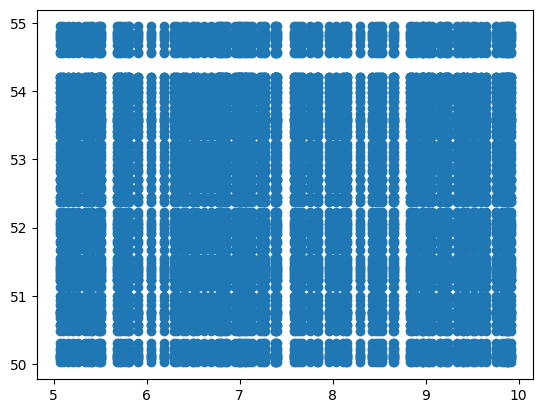

In [16]:
plt.scatter(data_xr.xv, data_xr.yv) #Original complete data-set

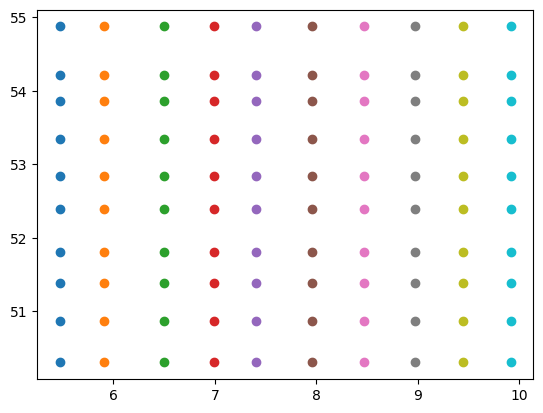

In [17]:
#Plotting subset after densification
for i in np.unique(raster):
    if i is not np.nan:
        plt.scatter(data_xr.xv[np.int64(i)], data_xr.yv[np.int64(i)])
        

Case 2: Non-sorted points

In [18]:
n_points = 400
n_time = 1

In [19]:
xx = (np.random.random(400)*(maxx - minx) + minx)
yy = (np.random.random(400)*(maxy - miny) + miny)
xxreshape = xx.reshape(n_points,1)
yyreshape = yy.reshape(n_points,1)

In [20]:
stack_xx_c2 = np.empty((n_points,0))
stack_yy_c2 = np.empty((n_points,0))

for i in range(1):
    stack_xx_c2 = np.append(stack_xx_c2, xxreshape, axis=1)
    stack_yy_c2 = np.append(stack_yy_c2, yyreshape, axis=1)

data_xr_c2 = xr.Dataset(data_vars=dict(xv=(["points","time"],stack_xx_c2),yv=(["points","time"],stack_yy_c2),),
                     coords=dict(
                        points=np.arange(n_points),
                        time=np.arange(n_time),
                        ))

data_xr_c2

<xarray.Dataset>
Dimensions:  (points: 400, time: 1)
Coordinates:
  * points   (points) int64 0 1 2 3 4 5 6 7 ... 392 393 394 395 396 397 398 399
  * time     (time) int64 0
Data variables:
    xv       (points, time) float64 5.639 6.188 7.136 ... 8.378 8.206 6.554
    yv       (points, time) float64 50.02 52.78 51.95 ... 51.03 54.03 54.35

In [21]:
df = data_xr_c2.to_dataframe().reset_index()

gdf = gpd.GeoDataFrame(
    df.index, geometry=gpd.points_from_xy(df.xv,df.yv))

grid_cell  = ((shapes) for shapes in zip(gdf.geometry, gdf.index))
raster = rasterio.features.rasterize(shapes=grid_cell, out_shape =[10,10], fill=np.NAN, all_touched= True, default_value=1, transform=affine.Affine.from_gdal(5.0, 0.5, 0.0, 54.9, 0.0, -0.5)) #, merge_alg= MergeAlg.replace
print (raster)

[[371. 256. 379. 369. 289. 279. 334. 278. 255. 320.]
 [323. 381. 387. 399. 235. 181. 398. 375. 328. 382.]
 [330. 296.  nan 238. 210. 331. 294. 347. 374. 288.]
 [236. 362. 275. 166.  nan  24. 276. 366. 336. 217.]
 [341. 390. 367.  90. 343. 220. 257. 372. 363. 396.]
 [389. 353. 383. 129. 352.  83. 266. 357. 380. 305.]
 [283. 384. 326. 120. 230. 356. 308. 151. 322. 154.]
 [281. 393. 378. 346. 329. 262. 397. 388. 324. 338.]
 [385. 368. 282. 333. 355. 394. 197. 268. 365. 360.]
 [395. 335. 277. 280. 261. 392.  nan 386. 345. 284.]]


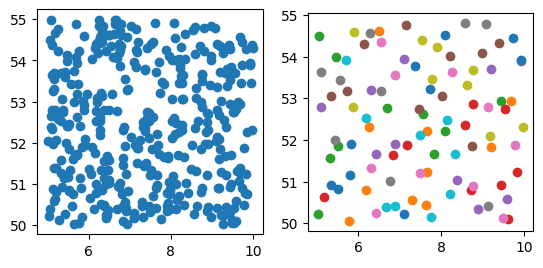

In [22]:
plt.subplot(1, 2, 1, aspect = 'equal')
plt.scatter(data_xr_c2.xv, data_xr_c2.yv) #Original complete data-set

plt.subplot(1, 2, 2, aspect = 'equal')
#Plotting subset after densification
for i in np.unique(raster):
    if not np.isnan(i):
        plt.scatter(data_xr_c2.xv[np.int64(i)], data_xr_c2.yv[np.int64(i)])

Case 3: Clustered points around 3 regions

In [23]:
n_points = 900
n_time = 1

#Defining mean for clustering around
xmeans = [5.5, 8.5, 7]
ymeans = [51, 53, 54.5]
xvar = 2
yvar = 2

xxreshape = np.empty((n_points,1))
yyreshape = np.empty((n_points,1))

xxreshape[0:300,0] = ((np.random.random(300)-0.5)*(xvar) + xmeans[0])
yyreshape[0:300,0] = ((np.random.random(300)-0.5)*(yvar) + ymeans[0])

xxreshape[300:600,0] = ((np.random.random(300)-0.5)*(xvar) + xmeans[1])
yyreshape[300:600,0] = ((np.random.random(300)-0.5)*(yvar) + ymeans[1])

xxreshape[600:900,0] = ((np.random.random(300)-0.5)*(xvar) + xmeans[2])
yyreshape[600:900,0] = ((np.random.random(300)-0.5)*(yvar) + ymeans[2])

#xxreshape = xx.reshape(n_points,1)
#yyreshape = yy.reshape(n_points,1)

In [24]:
stack_xx_c3 = np.empty((n_points,0))
stack_yy_c3 = np.empty((n_points,0))

for i in range(1):
    stack_xx_c3 = np.append(stack_xx_c3, xxreshape, axis=1)
    stack_yy_c3 = np.append(stack_yy_c3, yyreshape, axis=1)

data_xr_c3 = xr.Dataset(data_vars=dict(xv=(["points","time"],stack_xx_c3),yv=(["points","time"],stack_yy_c3),),
                     coords=dict(
                        points=np.arange(n_points),
                        time=np.arange(n_time),
                        ))

data_xr_c3

<xarray.Dataset>
Dimensions:  (points: 900, time: 1)
Coordinates:
  * points   (points) int64 0 1 2 3 4 5 6 7 ... 892 893 894 895 896 897 898 899
  * time     (time) int64 0
Data variables:
    xv       (points, time) float64 5.246 5.549 4.652 ... 7.086 6.567 7.533
    yv       (points, time) float64 50.98 50.4 51.16 51.62 ... 53.57 54.5 54.93

In [25]:
df = data_xr_c3.to_dataframe().reset_index()
df

,points,time,xv,yv
0,0,0,5.246242,50.978521
1,1,0,5.548557,50.395734
2,2,0,4.651599,51.156094
3,3,0,4.688502,51.615363
4,4,0,5.787182,51.146569
...,...,...,...,...
895,895,0,6.198626,53.595826
896,896,0,6.705343,54.672159
897,897,0,7.086320,53.569009
898,898,0,6.567081,54.497450


In [26]:
gdf = gpd.GeoDataFrame(
    data_xr_c3.points, geometry=gpd.points_from_xy(data_xr_c3.xv,data_xr_c3.yv))

gdf

,0,geometry
0,0,POINT (5.24624 50.97852)
1,1,POINT (5.54856 50.39573)
2,2,POINT (4.65160 51.15609)
3,3,POINT (4.68850 51.61536)
4,4,POINT (5.78718 51.14657)
...,...,...
895,895,POINT (6.19863 53.59583)
896,896,POINT (6.70534 54.67216)
897,897,POINT (7.08632 53.56901)
898,898,POINT (6.56708 54.49745)


In [27]:
df = data_xr_c3.to_dataframe().reset_index()

gdf = gpd.GeoDataFrame(
    df.index, geometry=gpd.points_from_xy(df.xv,df.yv))

grid_cell  = ((shapes) for shapes in zip(gdf.geometry, gdf.index))
raster = rasterio.features.rasterize(shapes=grid_cell, out_shape =[10,10], fill=np.NAN, all_touched= True, default_value=1, transform=affine.Affine.from_gdal(5.0, 0.5, 0.0, 54.9, 0.0, -0.5)) #, merge_alg= MergeAlg.replace
print (raster)

[[ nan  nan 884. 898. 882. 894.  nan  nan  nan  nan]
 [ nan  nan 889. 891. 878. 871. 588. 331. 458.  nan]
 [ nan  nan 895. 892. 897. 846. 598. 596. 560.  nan]
 [ nan  nan  nan  nan  nan 564. 574. 599. 561.  nan]
 [ nan  nan  nan  nan  nan 594. 593. 591. 578.  nan]
 [246. 137. 278.  nan  nan 589. 587. 575. 583.  nan]
 [296. 299. 288.  nan  nan  nan  nan  nan  nan  nan]
 [293. 275. 264.  nan  nan  nan  nan  nan  nan  nan]
 [284. 271. 282.  nan  nan  nan  nan  nan  nan  nan]
 [269. 298. 292.  nan  nan  nan  nan  nan  nan  nan]]


(46,)


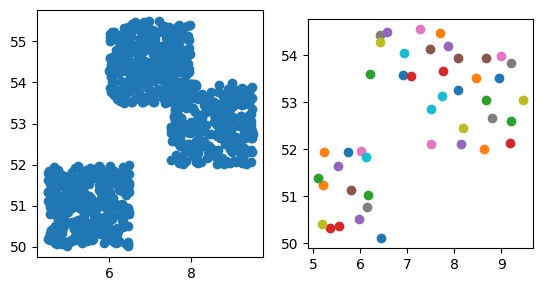

In [28]:
plt.subplot(1, 2, 1, aspect = 'equal')
plt.scatter(data_xr_c3.xv, data_xr_c3.yv) #Original complete data-set

plt.subplot(1, 2, 2, aspect = 'equal')
#Plotting subset after densification
for i in np.unique(raster):
    if not np.isnan(i):
        plt.scatter(data_xr_c3.xv[np.int64(i)], data_xr_c3.yv[np.int64(i)])

print (np.unique(raster).shape)